In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional, List, Union
from numpy.linalg import norm

df = pd.read_excel("zbior_punktow.xlsx", 'Arkusz2')
dct = dict()
pkt_nazwa = list(df['U'])
pkt_x = list(df['x'])
pkt_y = list(df['y'])
for i in range(len(pkt_x)):
    dct[pkt_nazwa[i]] = (pkt_x[i], pkt_y[i])

df2 = pd.read_excel("zbior_punktow.xlsx", 'Arkusz3')

A0_idx = df2.A0.to_list()
A1_idx = df2.A1.to_list()
A2_idx = df2.A2.to_list()
A3_idx = df2.A3.to_list()

A0 = []
A1 = []
A2 = []
A3 = []

for i in range(len(A0_idx)):
    A0.append(dct[A0_idx[i]])
    A1.append(dct[A1_idx[i]])
    A2.append(dct[A2_idx[i]])
    A3.append(dct[A3_idx[i]])

B0 = []

A1xmin = min([point[0] for point in A1])
A2xmax = max([point[0] for point in A2])

for point_name in dct.keys():
    if A1xmin < dct[point_name][0] < A2xmax:
        if (dct[point_name] not in A1) and (dct[point_name] not in A2) and (dct[point_name] not in A0) and (dct[point_name] not in A3):
            B0.append(dct[point_name])

In [158]:
def plot_points(zbior: Optional[Union[Dict, List]], dct: Dict=dct):
    # plt.figure(figsize=(20, 15))

    if isinstance(zbior, Dict):
        fig, ax = plt.subplots()
        fig.set_size_inches((20, 15))
        ax.set_ylim((0, 40))
        ax.set_xlim((0, 50))

        ax.scatter([zbior[point][0] for point in zbior.keys()], [zbior[point][1] for point in zbior.keys()])

        for key, coords in zbior.items():
            ax.annotate(key, coords)

    if isinstance(zbior, List):
        fig, ax = plt.subplots()
        fig.set_size_inches((20, 15))
        ax.set_ylim((0, 40))
        ax.set_xlim((0, 50))

        ax.scatter([point[0] for point in zbior], [point[1] for point in zbior])

        # dct = list(zbior.keys())[list(zbior.values()).index((point[0], point[1]))]
        

        for coords in zbior:
            key = list(dct.keys())[list(dct.values()).index((coords[0], coords[1]))]
            ax.annotate(key, coords)


def krzywa_woronoya(u, A1_point, A2_point):
    """
    Przyjmuje jako parametry dct[u] w postaci np. u = 'N11' 
    """
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 7))
    ax.set_ylim((0, 40))
    ax.set_xlim((0, 50))
    _, f1, f2, _ = stworz_krzywa(A1_point, A2_point)
    zbior = [u, A1_point, f1, f2, A2_point]

    zbior_to_text = [u, A1_point, A2_point]
    ax.scatter([point[0] for point in zbior], [point[1] for point in zbior])

    # dct = list(zbior.keys())[list(zbior.values()).index((point[0], point[1]))]
    ax.plot([zbior[i][0] for i in range(1, len(zbior))], [zbior[i][1] for i in range(1, len(zbior))])
    for coords in zbior_to_text:
        key = list(dct.keys())[list(dct.values()).index((coords[0], coords[1]))]
        ax.annotate('  '+key+f' {coords}', coords)
    ax.annotate(f'f1: {f1}', f1)
    ax.annotate(f'f2: {f2}', f2)


(0.0, inf, inf, 0.0)


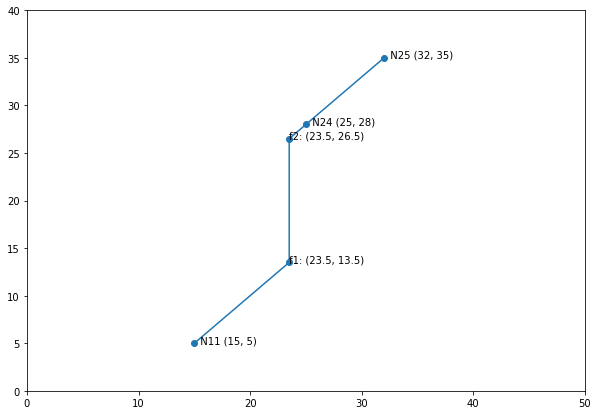

In [159]:
def oblicz_d(A1_point,A2_point):
    x_A1, y_A1 = A1_point
    x_A2, y_A2 = A2_point
    d1 = (x_A2 - x_A1)/2
    d2 = (y_A2 - y_A1)/2
    # print(d1,d2)
    # if d1 > d2:
    #     d1, d2 = d2, d1
    return min(d1,d2)

def stworz_krzywa(A1_point,A2_point):
    d = oblicz_d(A1_point,A2_point)
    x_A1, y_A1 = A1_point
    x_A2, y_A2 = A2_point
    f1 = (x_A1+d,y_A1+d) 
    f2 = (x_A2-d,y_A2-d)
    return (A1_point,f1,f2,A2_point)

# def oblicz_odleglosc(u,A1_point,A2_point):
#     A1_point, f1, f2, A2_point = stworz_krzywa(A1_point,A2_point)
#     # print(A1_point, f1, f2, A2_point)
#     lista = [A1_point, f1, f2, A2_point]
#     x_u, y_u = u
#     odle = []
#     for i in range(3):
#         if lista[i][0]-lista[i+1][0] == 0:
#             A = 0
#             B = -1
#             C = 0
#         else: 
#             B = -1
#             A = (lista[i][1]-lista[i+1][1])/(lista[i][0]-lista[i+1][0])
#             C = lista[i][1] - lista[i][0]*(lista[i][1]-lista[i+1][1])/(lista[i][0]-lista[i+1][0])
#         odle.append((abs(A*x_u + B*y_u + C))/(A**2+B**2)**(1/2))
#     return min(odle), odle.index(min(odle)), f1, f2

# def oblicz_odleglosc(u, A1_point, A2_point):
#     A1_point, f1, f2, A2_point = stworz_krzywa(A1_point,A2_point)
#     # print(A1_point, f1, f2, A2_point)
#     lista = [A1_point, f1, f2, A2_point]
#     x_u, y_u = u

#     a1 = (f1[1] - A1_point[1])/(f1[0] - A1_point[0])
#     b1 = f1[1]-(a1*f1[0])

    
#     a_prost = -1*a1
#     b_prost = f1[1]/(a_prost*f1[0])

#     y_prost = lambda x: a_prost*x+b_prost

#     d1 = np.Inf
#     d2 = np.Inf
#     d3 = np.Inf
#     # print(a1, b1)
    
#     # dla 1 przypadku odcinek A1_point do f1
#     if y_prost(x_u) < y_u:
#         d1 = ((x_u - f1[0])**2 + (y_u - f1[1])**2)**(1/2)
#     else:
#         d1 = abs(a1*x_u-y_u + b1)/(a1**2+1)**0.5

#     # dla 2 przypadku odcinek f1, f2
#     if f1[0] == f2[0]:
#         if f1[1] > y_u:
#             d2 = ((x_u - f1[0])**2 + (y_u - f1[1])**2)**(1/2)
#         else:
#             d2 = abs(f1[1]-y_u)
#     else:
#         # 1 przypadek - punkt x_u znajduje się przed f1[0]
#         if x_u < f1[0]:
#             d2 = ((x_u - f1[0])**2 + (y_u - f1[1])**2)**(1/2)
        
#         elif f1[0] < x_u < f2[0]:
#             d2 = abs(y_u-f1[1])
        
#         else:
#             # wieksze od f2
#             d2 = ((x_u - f2[0])**2 + (y_u - f2[1])**2)**(1/2)

#     # dla 3 przypadku odcinek f2, A2_point
#     a2 = (A2_point[1] - f2[1])/(A2_point[0] - f2[0])
#     b2 = f2[1]-(a2*f2[0])

#     a2_prost = -1*a2
#     b2_prost = f2[1]/(a2_prost*f2[0])

#     y2_prost = lambda x: a2_prost*x+b2_prost

#     if y2_prost(x_u) > y_u:
#         d3 = ((x_u - f2[0])**2 + (y_u - f2[1])**2)**(1/2)
    
#     else:
#         d3 = abs(a2*x_u-y_u + b2)/(a2**2+1)**0.5
    
#     print(d1, d2, d3)
#     return min(d1, d2, d3), f1, f2

def odleglosc(u, A1_odc, A2_odc):
    #  Funkcja obliczające odleglosc punktu od prostej 
    # zawierajacej odcinek nie uwzględnia przypadku jeżeli
    # punkt nie zawiera się w odcinku
    u = np.asarray(u)
    A1_odc = np.asarray(A1_odc)
    A2_odc = np.asarray(A2_odc)

    d = norm(np.cross(A2_odc-A1_odc, A1_odc-u))/norm(A2_odc-A1_odc)
    return d

def oblicz_dlugosc_odcinka(point_1, point_2):
    x_1, y_1 = point_1
    x_2, y_2 = point_2
    return ((x_2-x_1)**2 + (y_2 - y_1)**2)**(1/2)

def sprawdz_czy_punkt_u_w_odcinku_AB(u, point_1, point_2):
    """
    https://matematyka.pl/viewtopic.php?t=372091
    Znając współrzędne punktu P i końców odcinka AB możesz policzyć odległości między nimi. Jeśli te długości tworzą trójkąt rozwartokątny i AB nie jest najdłuższym bokiem trójkąta to rzut punktu na prostą zawierającą odcinek jest poza nim.
    Kąt leżący naprzeciw boku a jest rozwarty w trójkącie o bokach a, b, c gdy 
    """
    odc_u_point_1 = oblicz_dlugosc_odcinka(u, point_1) # c
    odc_u_point_2 = oblicz_dlugosc_odcinka(u, point_2) # b
    odc_point_1_point_2 = oblicz_dlugosc_odcinka(point_1, point_2) # a

    # Czy punkt u znajduje się w odcinku AB
    result = False
    lst_odcinek = [odc_u_point_1, odc_point_1_point_2, odc_u_point_2]

    a_idx = lst_odcinek.index(max(lst_odcinek))
    a = lst_odcinek[a_idx]

    czy_trojkat_rozw = False
    if odc_point_1_point_2+odc_u_point_2 > odc_u_point_1 and odc_point_1_point_2+odc_u_point_1>odc_u_point_2 and odc_u_point_2+odc_u_point_1>odc_point_1_point_2:
        if odc_point_1_point_2**2+odc_u_point_2**2<odc_u_point_1**2 or odc_point_1_point_2**2+odc_u_point_1**2 < odc_u_point_2**2 or odc_u_point_2**2+odc_u_point_1**2<odc_point_1_point_2**2:
            czy_trojkat_rozw = True
        else:
            czy_trojkat_rozw = False
    
    if czy_trojkat_rozw and odc_point_1_point_2 != a:
        result = False
        
    else:
        result = True
    
    return result

    


def oblicz_odleglosc(u, A1_point, A2_point):
    A1_point, f1, f2, A2_point = stworz_krzywa(A1_point,A2_point)
    # print(A1_point, f1, f2, A2_point)
    lista = [A1_point, f1, f2, A2_point]
    x_u, y_u = u

    # https://stackoverflow.com/questions/39840030/distance-between-point-and-a-line-from-two-points
    
    # u = np.asarray(u)
    # f1 = np.asarray(f1)
    # f2 = np.asarray(f2)
    # A1_point = np.asarray(A1_point)
    # A2_point = np.asarray(A2_point)
    d1 = np.Inf
    d2 = np.Inf
    d3 = np.Inf
    # Odleglosc u od prostej A1_point, f1
    # d1 = norm(np.cross(f1-A1_point, A1_point-u))/norm(A1_point-u)
    # print("A1_point-f1", sprawdz_czy_punkt_u_w_odcinku_AB(u, A1_point, f1))
    if sprawdz_czy_punkt_u_w_odcinku_AB(u, A1_point, f1):
        d1 = odleglosc(u, A1_point, f1)
    # Odleglosc u od prostej f1, f2
    # d2 = norm(np.cross(f2-f1, f1-u))/norm(f1-u)
    if sprawdz_czy_punkt_u_w_odcinku_AB(u, f1, f2):
        d2 = odleglosc(u, f1, f2)
    # print("f1-f2", sprawdz_czy_punkt_u_w_odcinku_AB(u, f1, f2))
    # Odleglosc u od prostej f2, A2_point
    # d3 = norm(np.cross(A2_point-f2, f2-u))/norm(f2-u)
    if sprawdz_czy_punkt_u_w_odcinku_AB(u, f2, A2_point):
        d3 = odleglosc(u, f2, A2_point)
    # print("f2-A2_point", sprawdz_czy_punkt_u_w_odcinku_AB(u, f2, A2_point))
    return min(d1, d2, d3), d1, d2, d3
    

# print(oblicz_d(dct["N22"],dct['N12']))
# print(oblicz_odleglosc(dct['N22'],dct['N12'],dct['N5']))

# def odleglosc(point_1,point_2):
#     x_1, y_1 = point_1
#     x_2, y_2 = point_2
#     return ((x_2-x_1)**2 + (y_2 - y_1)**2)**(1/2)

def oblicz_wspolczynnik_skoringowy(u,A1_point,A2_point):
    # odle, idx, f1, f2 = oblicz_odleglosc(u,A1_point,A2_point)
    # odleglosci = [odleglosc(A1_point,f1),odleglosc(f1,f2),odleglosc(f2,A2_point)]
    # suma = odleglosci[0] + odleglosci[1] + odleglosci[2]
    y_max = A2_point[1]
    y_min = A1_point[0]
    return (u[1]-y_min)/(y_max-y_min)
    # suma_1 = suma/suma
    # # suma = 1
    # waga = odleglosci[idx]/suma
    # wsp_skoringowy = odle * waga
    # return wsp_skoringowy

ranking = []

for point in B0:
    suma = 0
    for A1_point in A1:
        for A2_point in A2:
            suma += oblicz_wspolczynnik_skoringowy(point,A1_point,A2_point)
            # krzywa_woronoya(point, A1_point, A2_point)
            # print("wspol", oblicz_wspolczynnik_skoringowy(point,A1_point,A2_point))
    point = list(dct.keys())[list(dct.values()).index((point[0], point[1]))]
    ranking.append((point,suma))

ranking = sorted(ranking, key = lambda tup: tup[1], reverse=False)
# print(oblicz_wspolczynnik_skoringowy())
# print(ranking)
X = oblicz_odleglosc(dct['N24'], dct['N11'], dct['N25'])
print(X)
krzywa_woronoya(dct['N24'], dct['N11'], dct['N25'])

In [160]:
# plt.figure()
# plt.scatter([dct['N11'][0], dct['N22'][0], dct['N25'][0]], [dct['N11'][1], dct['N22'][1], dct['N25'][1]])
# plt.plot([dct['N11'][0], X[1][0], X[2][0], dct['N25'][0]], [dct['N11'][1], X[1][1], X[2][1], dct['N25'][1]])
# plt.show()

oblicz_odleglosc(dct['N20'], dct['N11'], dct['N25'])
# sprawdz_czy_punkt_u_w_odcinku_AB(dct['N20'], dct['N11'], dct['N25'])

(0.5, inf, 0.5, inf)

(0.5, inf, 0.5, inf)

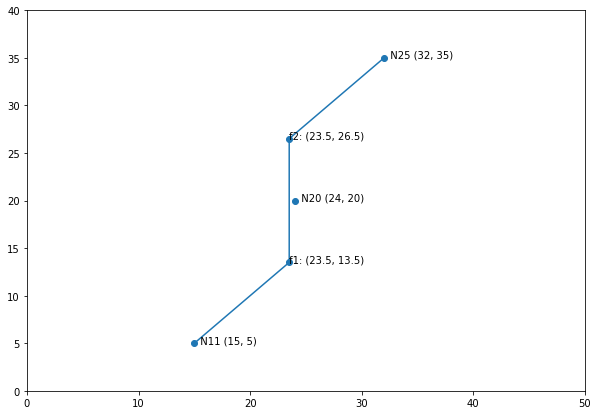

In [161]:
krzywa_woronoya(dct['N20'], dct['N11'], dct['N25'])
oblicz_odleglosc(dct['N20'], dct['N11'], dct['N25'])

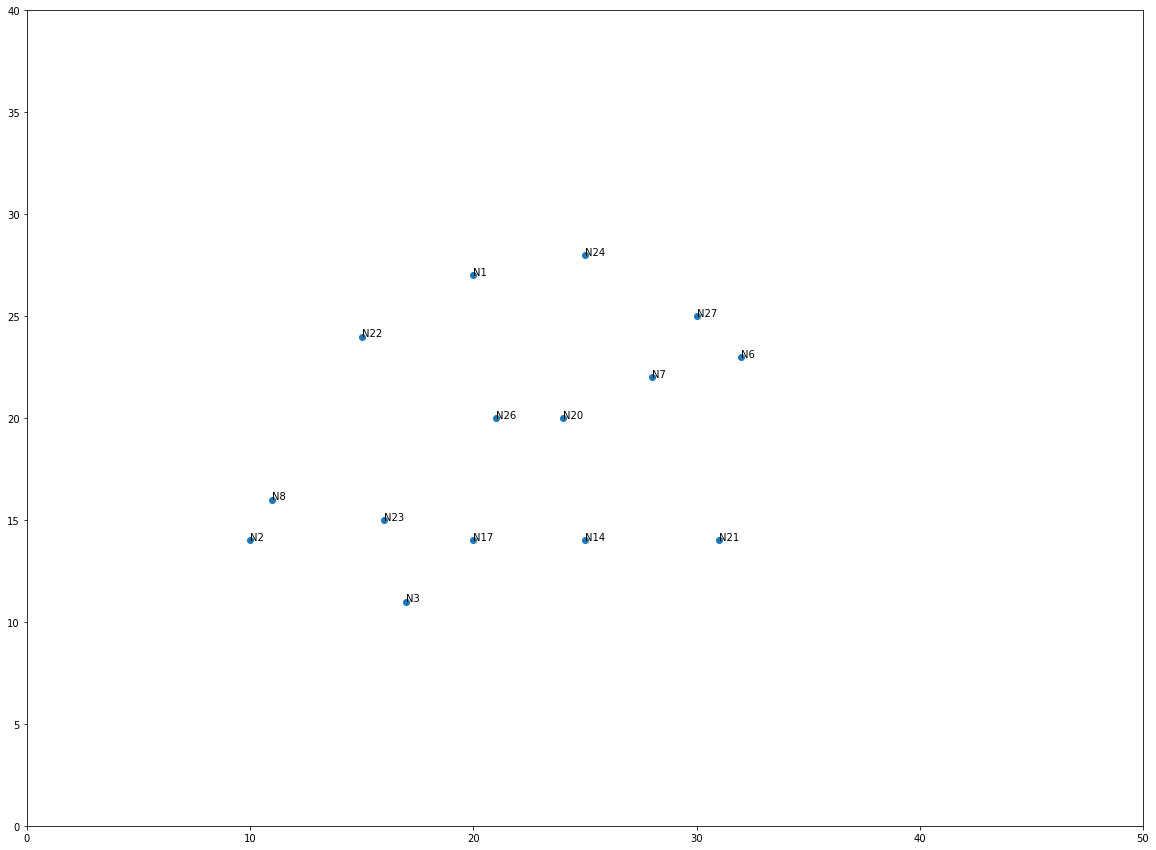

In [162]:
plot_points(B0)